# Introduction
## Content:
- Aim: To show how to use BayesRTO.py
1. Apply BayesRTO on Benoit Problem

In [33]:
import jax.numpy as jnp
import jax
from jax import grad, value_and_grad, jit, vmap
from scipy.optimize import minimize, fsolve
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import pandas as pd
from IPython.display import Image

import BayesRTOjax
import Benoit_Problem

# 1. Benoit Problem
## A. Code for Drawings and GIFs

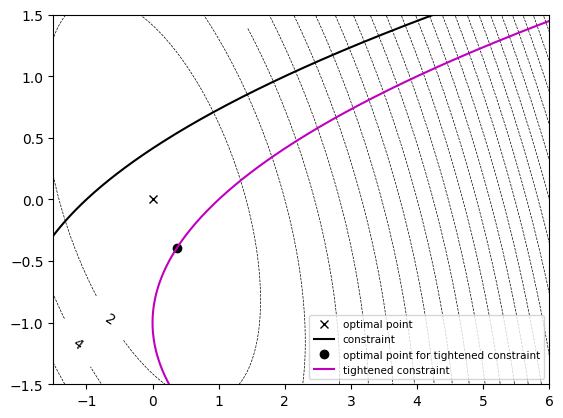

In [34]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = jnp.arange(-6.5, 6.5, delta)
        y = jnp.arange(-6.5, 6.5, delta)
        u = jnp.meshgrid(x, y)
        levels = jnp.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_Problem.Benoit_System_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                plt.plot(0,0,'kx')
                
                # Plot for constraint
                uc0 = 1. + x**2 + 2.*x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:
                # Plot for optimal value for optimization with tightened constraint
                plt.plot(0.36845785, -0.39299271,'ko')

                # Plot for tightened constraint
                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# Plot trust region circle
def trustregion_drawing(r,input_0,input_1):
       
        d_trial_x = jnp.linspace(-r, r, 50)
        d_trial_ypos= []
        d_trial_yneg = []
        equations = lambda d: [r - jnp.linalg.norm(d),d[0] - j]
        for j in d_trial_x: 
                initial_guess = [0,0]
                d = fsolve(equations,initial_guess)
                d_trial_ypos.append(d[1])
                d_trial_yneg.append(-d[1])

        d_trial_ypos = jnp.array(d_trial_ypos)
        d_trial_yneg = jnp.array(d_trial_yneg)

        plt.plot(d_trial_x+input_0,d_trial_ypos+input_1,'k-',linewidth=0.5)
        plt.plot(d_trial_x+input_0,d_trial_yneg+input_1,'k-',linewidth=0.5)

def BRTO_Benoit_drawing(data):
        plt.figure()
        # Drawing for Benoit's Problem
        plant_drawing(is_constraint = False,is_tight_constraint = True)

        # Plot points for input observed
        plt.plot(data['input_0'],data['input_1'], 'ro')
        plt.plot(data['input_0'],data['input_1'],'b-',linewidth=1,label='_nolegend_')

        n_iter = len(data['input_0'])
        for i in range(n_iter):
                trustregion_drawing(data['r'][i],data['input_0'][i],data['input_1'][i])

def create_frame(fun_drawing,t,filename):
        fun_drawing
        plt.savefig(filename)
        plt.close()

def create_GIF(frame_duration,filenames,GIFname):
        # create a GIF from saved frames
        frame_duration = 1000
        with imageio.get_writer(GIFname, mode='I', duration=frame_duration) as writer:
                for filename in filenames:
                        image = imageio.imread(filename)
                        writer.append_data(image)
        # remove individual frame files
        for filename in filenames:
                os.remove(filename)

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()



## B. Without Uncertainty

In [35]:
###################################################################################
###########################______GP Initialization______###########################
###################################################################################
'''
Description:
    It does as follows:
    1. Collects samples
    2. Find optimal parameters
    3. Initializes GP.
Arguments:
    n_sample        : number of samples to collect your input for GP initialization
    u_0             : initial input u (center point of area where you collect  of samples)
    theta_0         : initial parameter values for model [parameters for obj fun, parameters for constraint 1, parameters for constraint 2,...]
    r               : initial radius of trust region
    plant_system    : array with elements of plant objective function and constraints
    model           : array with elements of model objective function and constraints
Returns:
    GP_m            : a Gaussian Process Model
'''
BRTO = BayesRTOjax.Bayesian_RTO()

n_sample            = 4
u_0                 = jnp.array([4.,-1,])
r                   = 0.5
plant_system        = [Benoit_Problem.Benoit_System_1,
                       Benoit_Problem.con1_system_tight]

GP_m = BRTO.GP_Initialization(n_sample,u_0,r,plant_system)

#######################################################################################
###########################______Bayesian Optimization______###########################
#######################################################################################
n_iter = 10
b = 0.
# Dictionary for data collection
data = {}
data['input_0'] = [u_0[0]]
data['input_1'] = [u_0[1]]
data['GP model output'] = [GP_m.GP_inference_np(u_0)[0][0]]
data['GP model constraint'] = [GP_m.GP_inference_np(u_0)[0][1]]
data['plant output'] = [plant_system[0](u_0)]
data['plant constraint'] = [plant_system[1](u_0)]
data['r'] = [r]
# Parameters for GIF
filenames = []

for i in range(n_iter):
    print(f"iteration: {i}")
    # Create Frame
    t = i * 0.1
    filename = f'frame_{i:02d}.png'
    create_frame(BRTO_Benoit_drawing(data),t,filename)
    filenames.append(filename)

    # Bayesian Optimization
    # 1. New Observation
    d_new, obj= BRTO.optimize_acquisition(r,u_0,GP_m,b)    
    
    # 2. Collect data
    u_new = u_0 + d_new  
    output_new = []
    for plant in plant_system:
        output_new.append(plant(u_new))  

    # 3. Re-initialize Gaussian Process with new data                       
    GP_m.add_sample(u_new,output_new)                                                               

    # 4. Preparation for next iteration:
    u_0 = u_new

    # Data Collection
    GP_inference = GP_m.GP_inference_np(u_0)
    data['input_0'].append(u_0[0])
    data['input_1'].append(u_0[1])
    data['GP model output'].append(GP_inference[0][0])
    data['GP model constraint'].append(GP_inference[0][1])
    data['plant output'].append(plant_system[0](u_0))
    data['plant constraint'].append(plant_system[1](u_0))
    data['r'].append(r)

    if i == n_iter-1:
        # Create Last Frame
        t = n_iter * 0.1
        filename = f'frame_{n_iter:02d}.png'
        create_frame(BRTO_Benoit_drawing(data),t,filename)
        filenames.append(filename)

# Create GIF
frame_duration = 1000
GIFname = 'BRTO_Benoit.gif'
create_GIF(frame_duration,filenames,GIFname)

print(f"Final input: {data['input_0'][-1],data['input_1'][-1]}")

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
Final input: (Array(1.9638634, dtype=float32), Array(-0.99854463, dtype=float32))


### Graphical Illustration

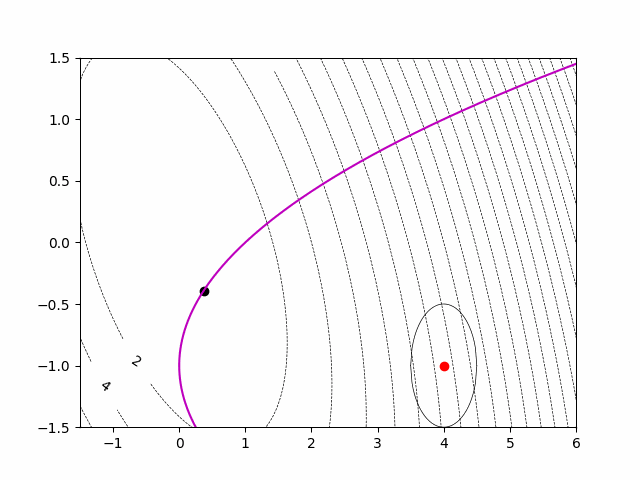

In [36]:
Image(filename='BRTO_Benoit.gif')

In [37]:
pd.DataFrame(data)

,input_0,input_1,GP model output,GP model constraint,plant output,plant constraint,r
0,4.0,-1.0,12.9699545,4.0219584,13.0,4.0,0.5
1,3.509533,-1.097173,9.38558,3.4960127,9.670045,3.5000904,0.5
2,2.8510432,-1.2284877,6.134905,2.799026,6.1351576,2.7988367,0.5
3,2.7739334,-1.0089979,5.9103503,2.7721436,5.91389,2.7738523,0.5
4,2.7731647,-1.0206081,5.924509,2.6065593,5.9017687,2.77274,0.5
5,2.7628698,-1.0507138,5.8344727,2.762191,5.834463,2.7602978,0.5
6,2.7919092,-1.0156994,5.99065,2.7916598,5.990662,2.7916627,0.5
7,2.8018126,-1.0084206,6.0387907,2.801681,6.041661,2.8017416,0.5
8,2.3047495,-1.0176194,4.002065,2.3044424,4.002062,2.304439,0.5
9,2.2537093,-1.0086912,3.9986212,2.2536352,3.8233666,2.2536337,0.5


## Can find following informations

In [38]:
# 1. Input samples initially created by number n_sample(argument) and used to initialize GP
print(f"Initial Input Sample: \n {BRTO.input_sample}")

Initial Input Sample: 
 [[ 4.1049113 -0.9459492]
 [ 3.8357959 -1.183889 ]
 [ 4.049353  -1.0392008]
 [ 3.8766966 -1.1924819]]
